In [1]:
__author__ = 'Erwin Chen'

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
from astropy.io import fits
from astropy.table import Table, join, Column, vstack
import numpy as np

style.use('fivethirtyeight')

In [2]:
def get_element(group, element):
    return group[element]
    
def get_label(element):
    element = element.replace(' ', '')
    if element == 'FE_H':
        label = element.replace('_H', '').title()
        return '[' + label + '/H]'
    else:
        label = element.replace('_FE', '').title()
        return '[' + label + '/Fe]'


In [3]:
filename = 'allStar-l31c.2.fits'

fits_file = fits.open(filename, memmap=True) # memory map deals with large fits files
data = fits_file[1].data

print(fits_file[1].header.keys)


<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                 6136 /Number of bytes per row                         
NAXIS2  =               277371 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                  208 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [4]:
## create column labels for data 

feature_names = ['APOGEE_ID', 'FIELD', 'GLON', 'GLAT', 'LOGG', 'TEFF', 'VHELIO_AVG', 'VSCATTER', 'SNR', 
                 'C_FE    ', 'CI_FE   ', 'N_FE    ', 'O_FE    ', 'NA_FE   ', 'MG_FE   ', 'AL_FE   ', 'SI_FE   ', 'P_FE    ', 'S_FE    ', 
                 'K_FE    ', 'CA_FE   ', 'TI_FE   ', 'TIII_FE ', 'V_FE    ', 'CR_FE   ', 'MN_FE   ', 'FE_H    ', 'CO_FE   ', 'NI_FE   ']
feature_names = [name.replace(' ', '') for name in feature_names]
element_names = feature_names[9:]

print("The following elements are in the data:")
print([get_label(element) for element in element_names])


The following elements are in the data:
['[C/Fe]', '[Ci/Fe]', '[N/Fe]', '[O/Fe]', '[Na/Fe]', '[Mg/Fe]', '[Al/Fe]', '[Si/Fe]', '[P/Fe]', '[S/Fe]', '[K/Fe]', '[Ca/Fe]', '[Ti/Fe]', '[Tiii/Fe]', '[V/Fe]', '[Cr/Fe]', '[Mn/Fe]', '[Fe/H]', '[Co/Fe]', '[Ni/Fe]']


In [5]:
## create an astropy table to store data

# data columns
cols = []
for name in feature_names:
    cols.append(data.field(name))
cols = np.array(cols)
cols = cols.T

# data type for each column
dtype = ['float' for n in range(len(feature_names))]
dtype[0] = 'string'
dtype[1] = 'string'

# create table
table_data = Table(data=cols, names=feature_names, dtype=dtype, masked=True)

fits_file.close()


In [6]:
## view data table
table_data


APOGEE_ID,FIELD,GLON,GLAT,LOGG,TEFF,VHELIO_AVG,VSCATTER,SNR,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
VESTA,calibration,292.21913091,-30.6029193637,-9999.0,5723.83886719,15.8273000717,10.6379003525,406.069000244,0.0247771032155,-9999.0,0.0303756855428,-0.010597165674,-9999.0,-0.0263949558139,0.0593749321997,0.0103172175586,-9999.0,-0.0829507634044,0.0668979585171,-0.0308769494295,-0.0708027407527,-9999.0,0.155532136559,-2.33671927452,-0.0231860019267,0.02656910941,-9999.0,0.0470079816878
2M00000002+7417074,120+12,119.401807224,11.7674135415,0.727418541908,3738.6262207,-52.1689987183,0.158675998449,859.487976074,0.00842110067606,0.0128981024027,0.276470094919,0.0723791718483,-9999.0,0.025506451726,-0.0312197804451,-0.0169928818941,-0.0918797254562,-0.139856114984,0.0815624594688,-0.0159722790122,0.121398471296,0.165653556585,0.195934534073,0.0426662564278,0.116418659687,-0.106735244393,0.121839255095,-0.00728538632393
2M00000019-1924498,060-75,63.3941216597,-75.90639677,-9999.0,5591.62402344,18.6497001648,0.0,142.705993652,0.0224562585354,-9999.0,0.013278901577,0.222008958459,-9999.0,0.165732741356,0.342372477055,0.0660071671009,-9999.0,0.082331776619,-0.0316987037659,0.0434949398041,0.109594173729,-9999.0,0.173506364226,-0.0476739108562,-0.136840552092,-0.194706499577,-9999.0,0.00224542617798
2M00000032+5737103,N7789,116.065370948,-4.56476751408,-9999.0,6197.46142578,-20.0746002197,0.188705995679,215.31300354,0.0602878928185,0.173107892275,0.0273278951645,0.199215352535,-0.480484634638,0.0579652488232,-0.200200021267,0.0640814304352,-0.929889202118,0.297398984432,0.0546471774578,-0.160551398993,-9999.0,-0.230576187372,-0.028692305088,0.230178818107,-0.0543875396252,-0.292121261358,0.722284197807,0.0186650454998
2M00000032+5737103,116-04,116.065370948,-4.56476751408,-9999.0,6091.83300781,-20.7598991394,0.0671320036054,120.399002075,0.0873779058456,0.25925591588,0.0744179189205,0.173125356436,-0.383584558964,0.0547112524509,-0.195740044117,0.0671284496784,-1.29596924782,0.16948902607,0.0734171867371,-0.218611419201,0.455598831177,-0.429006159306,-0.024872303009,-1.88023090363,0.0374924838543,-0.315241277218,0.68230420351,-0.0786349475384
2M00000068+5710233,N7789,115.977153525,-5.00239236973,3.35494399071,4987.14550781,-12.1689996719,0.134229004383,296.792999268,-0.12043427676,-0.0833922848105,0.14545571804,-0.0528378412127,0.0963615477085,0.0297792181373,-0.0424080714583,-0.0463170036674,-0.018259011209,-0.0268856957555,-0.00527333468199,-0.00345378369093,0.0136638507247,-9999.0,0.00473733246326,-0.012775413692,-0.0340727493167,-0.123485185206,-0.71940433979,0.0471196323633
2M00000211+6327470,117+01,117.22798534,1.16216678524,2.41941475868,4693.61767578,-107.013999939,0.0656917989254,105.277999878,-0.188680067658,-0.337740063667,0.417499929667,-0.0369104892015,-0.177388086915,-0.0348052531481,-0.0946377813816,-0.0254546646029,-0.159175395966,0.0545762591064,-0.0265839081258,-0.00065747462213,-0.0539434403181,-0.095597691834,0.096386231482,-0.087821982801,-0.0103974854574,0.0152868675068,-0.294449657202,0.0168947838247
2M00000222+5625359,N7789,115.831519392,-5.73468700864,3.27002263069,5062.22460938,-44.0667991638,9.01237010956,73.2988967896,-0.104861102998,-0.125401109457,0.196228891611,0.0615913420916,-0.18332657218,0.00615963339806,-0.165900021791,-0.00331573933363,0.10378575325,0.130500003695,0.0777501985431,0.0160286128521,-0.0637801662087,0.35481479764,-0.0436293110251,-0.197543174028,-0.0446894988418,-0.0921592786908,0.0538222044706,-0.038176946342
2M00000233+1452324,105-45,104.845530012,-46.1831575822,-9999.0,4821.93066406,-38.9056015015,0.0224882997572,199.669006348,0.031347244978,-0.0416947901249,0.0563688278198,-0.0900811254

In [7]:
## load membership information

known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
member_IDs = known_clusters[0]
member_names = known_clusters[1]
cluster_names = list(set(member_names)) # a list of distinct cluster names

# generate numeric labels for cluster members
members_labels = np.zeros(len(member_IDs))-1
k = 0
for name in cluster_names:
    members_labels[member_names == name] = k
    k += 1

for name in cluster_names:
    print("{: >10} has {: >3} members in the data".format(name, len(member_names[member_names == name])))


     N7789 has   5 members in the data
       M71 has   7 members in the data
     N6819 has  30 members in the data
     N6791 has  23 members in the data
      M107 has  18 members in the data
       M53 has  16 members in the data
     N2158 has  10 members in the data
       M35 has   1 members in the data
       M92 has  48 members in the data
       M67 has  24 members in the data
     N4147 has   3 members in the data
        M5 has 103 members in the data
       M13 has  71 members in the data
     N5466 has   8 members in the data
        M3 has  73 members in the data
        M2 has  19 members in the data
       M15 has  11 members in the data
  Pleiades has  75 members in the data
      N188 has   5 members in the data
     N2420 has   9 members in the data


In [8]:
## load membership into a table

names = ['APOGEE_ID', 'cluster_name', 'cluster_label']
dtype=['string', 'string', 'int']
table_member = Table(data=[member_IDs, member_names, members_labels], names=names, dtype=dtype)


In [9]:
## view membership table 
table_member


APOGEE_ID,cluster_name,cluster_label
str18,str18,int32
2M17162228+4258036,M92,8
2M17163427+4307363,M92,8
2M17163577+4256392,M92,8
2M17164330+4304161,M92,8
2M17165035+4305531,M92,8
2M17165118+4306434,M92,8
2M17165185+4308031,M92,8
2M17165519+4301588,M92,8
2M17165551+4305034,M92,8


In [10]:
## join data table and membership table

table_data = join(table_data, table_member, keys='APOGEE_ID', join_type='left') 


In [11]:
table_data['FE_H', 'cluster_name', 'cluster_label']

FE_H,cluster_name,cluster_label
float64,str18,int32
-0.106735244393,--,--
-0.194706499577,--,--
-0.292121261358,--,--
-0.315241277218,--,--
-0.123485185206,--,--
0.0152868675068,--,--
-0.0921592786908,--,--
0.444883644581,--,--
-0.214675217867,--,--


In [12]:
## mask missing values and fill

table_data = Table(table_data, masked=True)

table_data['cluster_name'].fill_value = 'Background'
table_data['cluster_label'].fill_value = -1   

for element in element_names: 
    table_data[element].mask = table_data[element] == -9999.
    table_data[element].fill_value = -999.

table_data = table_data.filled()


In [13]:
## view data table 

table_data['FE_H', 'cluster_name', 'cluster_label']


FE_H,cluster_name,cluster_label
float64,str18,int32
-0.106735244393,Background,-1
-0.194706499577,Background,-1
-0.292121261358,Background,-1
-0.315241277218,Background,-1
-0.123485185206,Background,-1
0.0152868675068,Background,-1
-0.0921592786908,Background,-1
0.444883644581,Background,-1
-0.214675217867,Background,-1


In [14]:
## view a specific cluster

table_data[table_data['cluster_name'] == 'M13']


APOGEE_ID,FIELD,GLON,GLAT,LOGG,TEFF,VHELIO_AVG,VSCATTER,SNR,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,cluster_name,cluster_label
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,int32
2M16404298+3627418,M13,58.9814491389,41.1073126378,-9999.0,-9999.0,-243.49899292,0.313203006983,233.705001831,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,M13,12
2M16404298+3627418,M13,58.9814491389,41.1073126378,1.49918317795,4581.82519531,-244.841003418,0.0560421012342,259.42098999,-0.48397564888,0.00907528400421,0.559814333916,0.246729850769,-999.0,0.23365521431,-0.256354808807,0.257706284523,-0.120199203491,0.294739484787,-0.00698375701904,0.173373818398,-0.0233162641525,0.53675699234,0.112717628479,-0.104955077171,-0.446062088013,-1.60780763626,0.11053609848,0.00958597660065,M13,12
2M16405539+3635433,M13,59.1638099841,41.0802765853,2.05510115623,4886.18212891,-247.820999146,0.206850007176,156.764007568,0.410318613052,0.540148615837,0.563238620758,0.229420185089,-999.0,0.279346108437,0.229004740715,0.341982722282,0.412297010422,0.121889352798,-0.016988158226,0.117168545723,0.259754061699,0.626135349274,0.307018995285,0.300010323524,-0.62783575058,-1.66581726074,0.107824921608,-0.197040557861,M13,12
2M16405637+3622185,M13,58.8694623968,41.052904645,2.18810486794,4922.81542969,-250.082992554,0.426470994949,64.505897522,-0.336063623428,-0.364983558655,-999.0,-0.151758432388,-999.0,0.0450452566147,0.689131438732,0.395915031433,0.0555266141891,0.537648439407,0.585742354393,-0.199720621109,0.205018639565,-0.401329040527,0.0259013175964,0.307133674622,-0.0318586826324,-1.65425658226,0.000420808792114,-0.242032289505,M13,12
2M16410260+3626158,M13,58.9593674616,41.0393333552,-9999.0,-9999.0,-243.468002319,0.311574995518,124.425003052,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,M13,12
2M16410648+3628136,M13,59.00439329,41.0299640109,1.66144490242,4715.74121094,-249.688995361,0.0516026988626,280.802001953,-0.366758942604,-0.37980890274,0.897041082382,-0.120417833328,-999.0,0.0843545198441,0.682316541672,0.209755897522,-1.00388526917,0.0946485996246,0.0976079702377,0.171114325523,0.087033867836,0.446921467781,0.167230248451,0.127628087997,-0.246092796326,-1.53847336769,-0.234694600105,-0.0684475898743,M13,12
2M16410966+3626448,M13,58.97342416,41.0166875188,2.25170612335,4946.20458984,-256.665985107,0.244122996926,132.947006226,-0.0902135372162,0.245403528214,0.240723490715,0.393179416656,-999.0,0.278736233711,-0.386246085167,0.277126312256,0.479411363602,0.0136123895645,0.0113191604614,0.185487389565,-0.00739109516144,-999.0,0.658727288246,-0.750954270363,-0.33488714695,-1.65828549862,0.00831317901611,-0.159715771675,M13,12
2M16411511+3623538,M13,58.9135100549,40.9933396185,2.24140238762,4912.5234375,-247.697998047,0.212606996298,66.927696228,-0.26113474369,0.317175269127,0.544025301933,0.214179158211,-999.0,0.197179794312,-0.186871647835,0.406780004501,0.86347591877,0.778488576412,0.212337136269,0.151471972466,0.396032691002,-999.0,0.641811490059,-0.508426308632,-0.381106972694,-1.66480958462,-999.0,-0.232904434204,M13,12
2M16411521+3629240,M13,59.0343316354,41.0030056143,-9999.0,-9999.0,-249.802993774,0.257600992918,75.8012008667,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,M13,12


In [15]:
## check valid values for each element

index_all_valid = np.arange(len(table_data))
for element in element_names:
    valid = np.where(np.abs(table_data[element]) < 999.)[0]
    index_all_valid = np.intersect1d(index_all_valid, valid)
    print("{: >10} has valid values for {: >6} stars".format(*[element, len(valid)]))
print("{} stars have valid values for all elements".format(len(index_all_valid)))


      C_FE has valid values for 227604 stars
     CI_FE has valid values for 193913 stars
      N_FE has valid values for 226538 stars
      O_FE has valid values for 228586 stars
     NA_FE has valid values for 128538 stars
     MG_FE has valid values for 229009 stars
     AL_FE has valid values for 220575 stars
     SI_FE has valid values for 229084 stars
      P_FE has valid values for 190468 stars
      S_FE has valid values for 224188 stars
      K_FE has valid values for 223771 stars
     CA_FE has valid values for 223574 stars
     TI_FE has valid values for 221069 stars
   TIII_FE has valid values for 159591 stars
      V_FE has valid values for 217109 stars
     CR_FE has valid values for 216871 stars
     MN_FE has valid values for 225792 stars
      FE_H has valid values for 229132 stars
     CO_FE has valid values for 162626 stars
     NI_FE has valid values for 227017 stars
118048 stars have valid values for all elements


In [16]:
## delete stars with missing values for any element

table_data.remove_rows(np.setdiff1d(np.arange(len(table_data)), index_all_valid))


In [17]:
## group stars by membership and show the number of members for every cluster

table_data_cluster = table_data.group_by('cluster_name')
indices = table_data_cluster.groups.indices
k = 0
for key in table_data_cluster.groups.keys:
    print("{: >10} has {: >6} members with valid values for all elements.".format(key[0], indices[k+1]-indices[k]))
    k += 1
    

Background has 117939 members with valid values for all elements.
      M107 has      3 members with valid values for all elements.
       M13 has      1 members with valid values for all elements.
        M2 has      1 members with valid values for all elements.
        M3 has      2 members with valid values for all elements.
        M5 has      3 members with valid values for all elements.
       M67 has     37 members with valid values for all elements.
       M71 has      3 members with valid values for all elements.
      N188 has      8 members with valid values for all elements.
     N2158 has      7 members with valid values for all elements.
     N2420 has      7 members with valid values for all elements.
     N6791 has      4 members with valid values for all elements.
     N6819 has     28 members with valid values for all elements.
     N7789 has      5 members with valid values for all elements.


In [18]:
## equivalently

for group in table_data_cluster.groups:
    print("{: >10} has {: >6} members with valid values for all elements.".format(group['cluster_name'][0], len(group)))
    

Background has 117939 members with valid values for all elements.
      M107 has      3 members with valid values for all elements.
       M13 has      1 members with valid values for all elements.
        M2 has      1 members with valid values for all elements.
        M3 has      2 members with valid values for all elements.
        M5 has      3 members with valid values for all elements.
       M67 has     37 members with valid values for all elements.
       M71 has      3 members with valid values for all elements.
      N188 has      8 members with valid values for all elements.
     N2158 has      7 members with valid values for all elements.
     N2420 has      7 members with valid values for all elements.
     N6791 has      4 members with valid values for all elements.
     N6819 has     28 members with valid values for all elements.
     N7789 has      5 members with valid values for all elements.


In [19]:
## view known members

table_data_cluster.groups[1:]


APOGEE_ID,FIELD,GLON,GLAT,LOGG,TEFF,VHELIO_AVG,VSCATTER,SNR,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,cluster_name,cluster_label
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,int32
2M16322112-1302516,M107,3.34973896153,23.0489622627,0.961548626423,4059.43847656,-37.2915000916,1.78380000591,483.615997314,-0.142319917679,-0.0236750841141,0.296050071716,0.278560221195,0.161572158337,0.280970394611,-0.202204942703,0.311052858829,-0.0184097290039,0.539673864841,0.0919874310493,0.103143453598,-0.124798297882,0.535923540592,-0.2637155056,-0.0386173725128,-0.323677301407,-1.05759358406,0.00621724128723,0.0893645882607,M107,4
2M16324155-1302038,M107,3.41588008293,22.9911232736,1.54792261124,4295.37890625,-38.5932006836,0.0417223013937,272.210998535,0.045836687088,0.142731666565,0.150371670723,0.345533788204,-0.0484583377838,0.359624058008,0.376795768738,0.459011614323,-0.0358613729477,0.436105102301,0.158296704292,0.223129034042,0.0707936882973,0.449708104134,-0.0887444615364,0.0333140492439,-0.334099292755,-0.858716011047,0.0113349556923,0.0711558461189,M107,4
2M16324652-1315120,M107,3.24028848004,22.8421821825,1.64640021324,4241.37841797,-42.3694000244,0.0855304002762,208.07699585,0.0188364312053,0.0361394286156,0.204729437828,0.123346716166,-0.016694240272,0.196427926421,0.009451597929,0.104174152017,-0.0418601222336,0.127823874354,0.0686794146895,-0.0166519992054,-0.0279965922236,0.058551594615,-0.118893623352,-0.022538036108,-0.146376028657,-0.0272791497409,0.00550147891045,-0.0140941664577,M107,4
2M16421910+3637033,M13,59.2328937145,40.8042958884,2.30949378014,5056.01416016,-243.707992554,0.210041999817,150.561004639,0.0279786586761,0.103621602058,0.953553617001,-0.220796585083,1.72108101845,0.208197593689,0.792197585106,0.340314388275,0.212693452835,0.18252158165,0.151317834854,0.284662008286,0.337849378586,0.7350897789,0.326594829559,0.423342585564,-0.415253400803,-1.63888716698,0.365297079086,-0.0861637592316,M13,12
2M21331854-0051563,054-35_MGA,53.3032606328,-35.7635819521,1.38234090805,4600.33886719,-3.07725000381,0.0413151010871,134.238998413,-0.442854881287,-0.256834864616,0.868205189705,0.407120704651,0.491465210915,0.147260785103,0.421338319778,0.220034718513,0.100916385651,0.274067401886,0.146060347557,0.176678180695,0.189057469368,0.360307216644,0.127461075783,0.224320650101,-0.26848077774,-1.47411394119,0.0671235322952,0.00304865837097,M2,15
2M13412055+2811492,M3,41.339256364,78.9033962219,1.82516050339,4939.00292969,-144.761993408,0.306712001562,218.815994263,-0.487008333206,-0.0936983823776,0.141931653023,-0.0627735853195,0.954333841801,0.184614419937,-0.309056758881,0.272949457169,-0.844250917435,0.404606580734,0.252311229706,0.0320012569427,-0.165122032166,0.886814117432,0.0394103527069,0.024588227272,-0.1821205616,-1.60796523094,1.08337068558,0.0058513879776,M3,14
2M13423140+2822543,037+79_MGA,42.2177509061,78.6342536302,1.51879417896,4471.33935547,-150.852996826,0.0,121.444000244,-0.322528243065,-0.0504393577576,0.289101719856,0.250041007996,0.913334727287,0.217119216919,-0.237654805183,0.291472792625,-0.107296347618,0.221740484238,0.0264103412628,0.176530599594,-0.0827552080154,0.721392095089,-0.0623958110809,0.238762617111,-0.262794733047,-1.38892805576,-0.395111203194,-0.0145251750946,M3,14
2M15183938+0158516,M5PAL5,3.76852840488,46.7135962742,2.37234473228,5008.98193359,50.9294013977,0.418902009726,100.240997314,-0.135830760002,-0.256510734558,0.811129271984,0.210483908653,0.302584528923,0.189042568207,0.319443702698,0.149726748466,-0.496682167053,0.449788331985,0.328122496605,0.112397909164,0.120046496391,0.496927678585,-0.291350722313,0.33379983902,-0.101939201355,-1.26609241962,-1.12215745449,-0.277077198029,M5,11
2M15184346+0156311,M5PAL5,3.73986902

In [20]:
## filter function

def Fe_nagative(table, key_colnames):
    if np.mean(table['FE_H']) < 0:
        return True
    return False


In [21]:
## filter groups with the filter function

table_data_neg = table_data_cluster.groups.filter(Fe_nagative)
print(table_data_neg.groups.keys)


cluster_name
------------
  Background
        M107
         M13
          M2
          M3
          M5
         M71
       N2158
       N2420


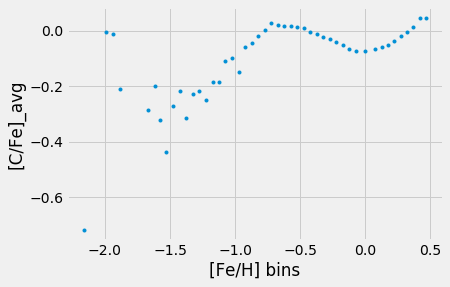

In [22]:
## binning 

Fe_bin = np.trunc(table_data['FE_H'] / 0.05)
Fe_grouped = table_data.group_by(Fe_bin)
Fe_binned = Fe_grouped['FE_H', 'C_FE'].groups.aggregate(np.mean)

plt.plot(Fe_binned['FE_H'], Fe_binned['C_FE'], '.')
plt.xlabel(get_label('FE_H') + ' bins')
plt.ylabel(get_label('C_FE') + '_avg')
plt.show()


In [23]:
M67 = table_data[table_data['cluster_name'] == 'M67']
N6819 = table_data[table_data['cluster_name'] == 'N6819']

vstack([M67, N6819])


APOGEE_ID,FIELD,GLON,GLAT,LOGG,TEFF,VHELIO_AVG,VSCATTER,SNR,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,cluster_name,cluster_label
str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,int32
2M08490674+1129529,M67,215.753868442,31.2833906427,2.51723361015,4620.44482422,33.4720001221,0.0495061986148,143.270996094,-0.0498099699616,-0.103666968644,0.213265031576,0.03714556247,-0.0164032429457,0.0681351348758,-0.0534010976553,-0.0568707510829,-0.374156594276,0.0484739467502,0.0618592724204,-0.0267914310098,-0.00760557316244,-0.14083468914,-0.0495347455144,0.004603786394,-0.0757210701704,0.0281093362719,-0.0517623275518,-0.00215379707515,M67,9
2M08490674+1129529,GD1-2,215.753868442,31.2833906427,2.57794737816,4624.97509766,33.6446990967,0.0761056989431,444.802001953,-0.0472692325711,-0.139125227928,0.203484773636,0.00970429554582,-0.187995225191,0.0544001981616,0.0254686251283,-0.000144068151712,-0.100192919374,-0.0378383807838,-0.000857543200254,0.0113405697048,-0.0187352672219,0.122930295765,0.0411997064948,-0.019802711904,-0.0656143277884,0.0472067072988,-0.0307917445898,-0.032142046839,M67,9
2M08492491+1144057,M67,215.538530631,31.4501384761,3.17053604126,4893.95263672,35.0889015198,1.50559997559,460.657989502,-0.179242163897,-0.231022164226,0.442047834396,-0.047017686069,0.142134651542,0.0195747464895,-0.0386764630675,-0.065009355545,0.0248422473669,-0.0352367758751,-0.0230541154742,-0.0235175937414,0.0604673624039,-0.111821137369,-0.0918394774199,-0.0337914526463,0.0139621645212,0.111567810178,0.0291403383017,0.0353028029203,M67,9
2M08492491+1144057,GD1-2,215.538530631,31.4501384761,3.16784071922,4932.41357422,26.121799469,5.54164981842,379.515014648,-0.144723206758,-0.253363192081,0.372866809368,-0.0182540714741,0.192669987679,0.0237309634686,-0.0182303860784,-0.00820686668158,-0.116827644408,-0.0753600522876,0.00715810060501,0.0118321180344,-0.0081992149353,-0.121714375913,-0.127903372049,-0.0675605535507,0.0304474830627,0.124254643917,0.0536408722401,0.0183373987675,M67,9
2M08510839+1147121,M67,215.690981332,31.855126593,3.26873016357,4949.33642578,33.5177001953,0.179874002934,170.804992676,-0.149223953485,-0.172223955393,0.357536017895,-0.0628550350666,0.164690330625,0.0125473588705,-0.0758524760604,-0.030208311975,-0.0122117847204,-0.0371678881347,-0.068093508482,-0.00773697346449,-0.00777051597834,-0.523516058922,-0.233400806785,-0.0474766381085,-0.00334072113037,0.0821972936392,0.0202040970325,0.0423285663128,M67,9
2M08510839+1147121,GD1-2,215.690981332,31.855126593,3.28443264961,4978.30957031,33.4567985535,0.0845751017332,342.320007324,-0.0673804432154,-0.168415442109,0.258134543896,-0.0321036018431,-0.0251599922776,0.0083244740963,-0.0535534247756,-0.0131946504116,-0.142740651965,-0.0824704840779,0.005450733006,-0.00873102247715,-0.0542256385088,0.00539072602987,0.0963938236237,0.0148018673062,0.0317445844412,0.0833669602871,-0.229573994875,0.0151332616806,M67,9
2M08511897+1158110,M67,215.516349316,31.970818889,3.22029185295,4956.91650391,34.0130996704,0.100369997323,384.933013916,-0.124995261431,-0.101275265217,0.372574716806,0.00061371922493,0.184336334467,0.0252566076815,-0.0380597040057,-0.0405188016593,0.00727355107665,0.0022860057652,-0.0173287801445,-0.0189225263894,0.0104561187327,-0.182558715343,0.0384567715228,0.00213894248009,0.0164483301342,0.051187183708,-0.0960284173489,0.0355144329369,M67,9
2M08511897+1158110,GD1-2,215.516349316,31.970818889,3.22305703163,4975.65771484,34.8083000183,0.0868521034718,393.830993652,-0.134087279439,-0.209967285395,0.357972741127,-0.0383443534374,-0.114152476192,0.00783464312553,-0.0173003189266,-0.0139073431492,-0.0281435474753,-0.0466406755149,-0.0286158584058,0.0087932497263,-0.0421170145273,-0.149468451738,-0.101438522339,0.